In [4]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import torch
import random
device = 'cuda' if torch.cuda.is_available() else 'cpu'
from scipy.ndimage import gaussian_filter
import os, sys
opj = os.path.join
from tqdm import tqdm
from functools import partial
import acd
from copy import deepcopy
sys.path.append('..')
from transforms_torch import bandpass_filter, bandpass_filter_augment
# plt.style.use('dark_background')
sys.path.append('../../dsets/mnist')
import dset
from model import Net, Net2c
from util import *
from numpy.fft import *
from torch import nn
import pickle as pkl

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# test on the images

In [5]:
# set args
args = dset.get_args()
args.cuda = not args.no_cuda and torch.cuda.is_available()

# load mnist data
train_loader, test_loader = dset.load_data(args.batch_size, args.test_batch_size, device)
# band centers
true_band_centers = np.linspace(0.15, 0.85, 20)
band_centers = np.linspace(0.11, 0.89, 120)

In [6]:
# load results
scores0 = pkl.load(open('scores0_orig','rb')).cpu().numpy()
scores1 = pkl.load(open('scores1_orig','rb')).cpu().numpy()
test_losses = pkl.load(open('losses','rb'))
accuracies = pkl.load(open('accuracies','rb'))

for i in range(len(test_losses)):
    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
        test_losses[i], accuracies[i], 2*len(test_loader.dataset),
        100. * accuracies[i] / (2*len(test_loader.dataset)))) 

Test set: Average loss: 0.0001, Accuracy: 19999/20000 (100%)
Test set: Average loss: 0.0000, Accuracy: 20000/20000 (100%)
Test set: Average loss: 0.0000, Accuracy: 20000/20000 (100%)
Test set: Average loss: 0.0000, Accuracy: 20000/20000 (100%)
Test set: Average loss: 0.0000, Accuracy: 20000/20000 (100%)
Test set: Average loss: 0.0000, Accuracy: 20000/20000 (100%)
Test set: Average loss: 0.0001, Accuracy: 20000/20000 (100%)
Test set: Average loss: 0.0006, Accuracy: 19997/20000 (100%)
Test set: Average loss: 0.0003, Accuracy: 20000/20000 (100%)
Test set: Average loss: 0.0007, Accuracy: 20000/20000 (100%)
Test set: Average loss: 0.0035, Accuracy: 19967/20000 (100%)
Test set: Average loss: 0.0000, Accuracy: 20000/20000 (100%)
Test set: Average loss: 0.0002, Accuracy: 19999/20000 (100%)
Test set: Average loss: 0.0003, Accuracy: 19999/20000 (100%)
Test set: Average loss: 0.0001, Accuracy: 19999/20000 (100%)
Test set: Average loss: 0.0000, Accuracy: 20000/20000 (100%)
Test set: Average loss: 

# cd transform score

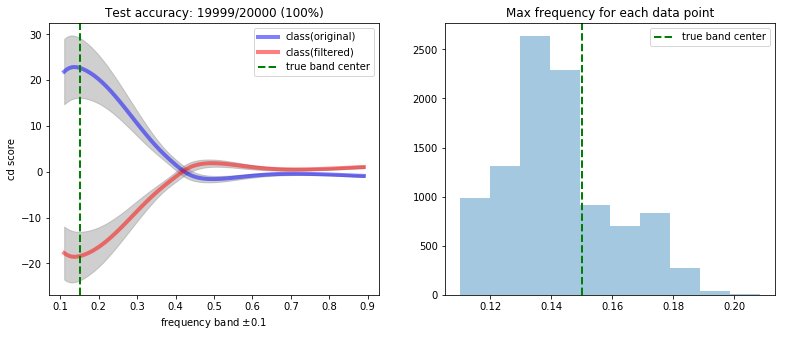

In [7]:
band_idx = 0
fig, ax = plt.subplots(1, 2, figsize=(13,5))
ax[0].plot(band_centers, scores0[band_idx,:].mean(axis=0), alpha=0.5, color='blue', label='class(original)', linewidth=4.0)
ax[0].fill_between(band_centers, scores0[band_idx,:].mean(axis=0)-scores0[band_idx,:].std(axis=0), 
                    scores0[band_idx,:].mean(axis=0)+scores0[band_idx,:].std(axis=0), color='#888888', alpha=0.4)
ax[0].plot(band_centers, scores1[band_idx,:].mean(axis=0), alpha=0.5, color='red', label='class(filtered)', linewidth=4.0)
ax[0].fill_between(band_centers, scores1[band_idx,:].mean(axis=0)-scores1[band_idx,:].std(axis=0), 
                    scores1[band_idx,:].mean(axis=0)+scores1[band_idx,:].std(axis=0), color='#888888', alpha=0.4)
ax[0].axvline(x=true_band_centers[band_idx], linestyle='--', color='green', label='true band center', linewidth=2.0)
ax[0].set_xlabel('frequency band $\pm 0.1$')
ax[0].set_ylabel('cd score')
ax[0].set_title('Test accuracy: {}/{} ({:.0f}%)'.format(accuracies[band_idx], 2*len(test_loader.dataset),
        100. * accuracies[band_idx] / (2*len(test_loader.dataset))))
ax[0].legend()

ax[1].hist(band_centers[np.argmax(scores0[band_idx,:],axis=1)], bins=10, alpha=0.4)
ax[1].axvline(x=true_band_centers[band_idx], linestyle='--', color='green', label='true band center', linewidth=2.0)
ax[1].legend()
ax[1].set_title('Max frequency for each data point')
plt.show()

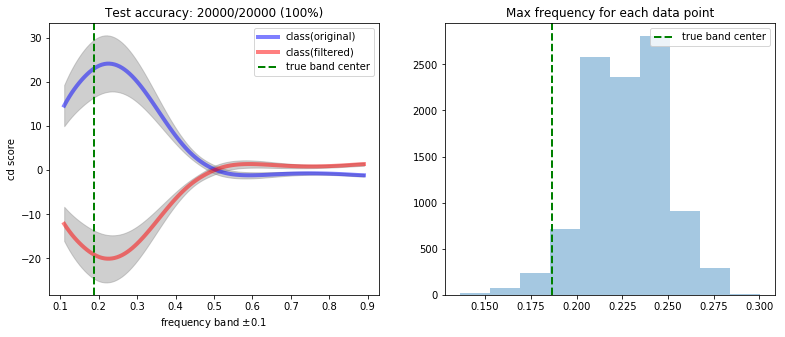

In [8]:
band_idx = 1
fig, ax = plt.subplots(1, 2, figsize=(13,5))
ax[0].plot(band_centers, scores0[band_idx,:].mean(axis=0), alpha=0.5, color='blue', label='class(original)', linewidth=4.0)
ax[0].fill_between(band_centers, scores0[band_idx,:].mean(axis=0)-scores0[band_idx,:].std(axis=0), 
                    scores0[band_idx,:].mean(axis=0)+scores0[band_idx,:].std(axis=0), color='#888888', alpha=0.4)
ax[0].plot(band_centers, scores1[band_idx,:].mean(axis=0), alpha=0.5, color='red', label='class(filtered)', linewidth=4.0)
ax[0].fill_between(band_centers, scores1[band_idx,:].mean(axis=0)-scores1[band_idx,:].std(axis=0), 
                    scores1[band_idx,:].mean(axis=0)+scores1[band_idx,:].std(axis=0), color='#888888', alpha=0.4)
ax[0].axvline(x=true_band_centers[band_idx], linestyle='--', color='green', label='true band center', linewidth=2.0)
ax[0].set_xlabel('frequency band $\pm 0.1$')
ax[0].set_ylabel('cd score')
ax[0].set_title('Test accuracy: {}/{} ({:.0f}%)'.format(accuracies[band_idx], 2*len(test_loader.dataset),
        100. * accuracies[band_idx] / (2*len(test_loader.dataset))))
ax[0].legend()

ax[1].hist(band_centers[np.argmax(scores0[band_idx,:],axis=1)], bins=10, alpha=0.4)
ax[1].axvline(x=true_band_centers[band_idx], linestyle='--', color='green', label='true band center', linewidth=2.0)
ax[1].legend()
ax[1].set_title('Max frequency for each data point')
plt.show()

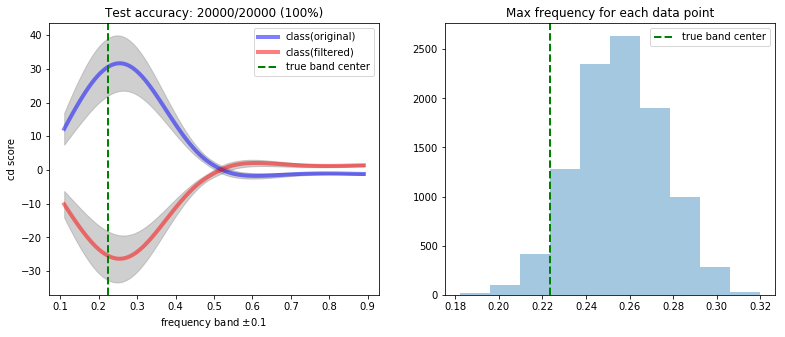

In [9]:
band_idx = 2
fig, ax = plt.subplots(1, 2, figsize=(13,5))
ax[0].plot(band_centers, scores0[band_idx,:].mean(axis=0), alpha=0.5, color='blue', label='class(original)', linewidth=4.0)
ax[0].fill_between(band_centers, scores0[band_idx,:].mean(axis=0)-scores0[band_idx,:].std(axis=0), 
                    scores0[band_idx,:].mean(axis=0)+scores0[band_idx,:].std(axis=0), color='#888888', alpha=0.4)
ax[0].plot(band_centers, scores1[band_idx,:].mean(axis=0), alpha=0.5, color='red', label='class(filtered)', linewidth=4.0)
ax[0].fill_between(band_centers, scores1[band_idx,:].mean(axis=0)-scores1[band_idx,:].std(axis=0), 
                    scores1[band_idx,:].mean(axis=0)+scores1[band_idx,:].std(axis=0), color='#888888', alpha=0.4)
ax[0].axvline(x=true_band_centers[band_idx], linestyle='--', color='green', label='true band center', linewidth=2.0)
ax[0].set_xlabel('frequency band $\pm 0.1$')
ax[0].set_ylabel('cd score')
ax[0].set_title('Test accuracy: {}/{} ({:.0f}%)'.format(accuracies[band_idx], 2*len(test_loader.dataset),
        100. * accuracies[band_idx] / (2*len(test_loader.dataset))))
ax[0].legend()

ax[1].hist(band_centers[np.argmax(scores0[band_idx,:],axis=1)], bins=10, alpha=0.4)
ax[1].axvline(x=true_band_centers[band_idx], linestyle='--', color='green', label='true band center', linewidth=2.0)
ax[1].legend()
ax[1].set_title('Max frequency for each data point')
plt.show()

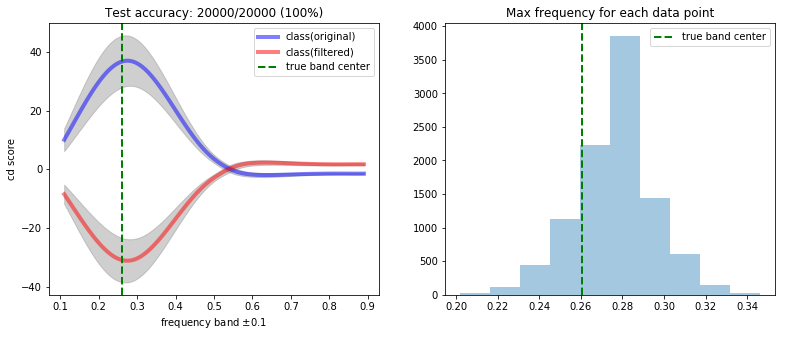

In [10]:
band_idx = 3
fig, ax = plt.subplots(1, 2, figsize=(13,5))
ax[0].plot(band_centers, scores0[band_idx,:].mean(axis=0), alpha=0.5, color='blue', label='class(original)', linewidth=4.0)
ax[0].fill_between(band_centers, scores0[band_idx,:].mean(axis=0)-scores0[band_idx,:].std(axis=0), 
                    scores0[band_idx,:].mean(axis=0)+scores0[band_idx,:].std(axis=0), color='#888888', alpha=0.4)
ax[0].plot(band_centers, scores1[band_idx,:].mean(axis=0), alpha=0.5, color='red', label='class(filtered)', linewidth=4.0)
ax[0].fill_between(band_centers, scores1[band_idx,:].mean(axis=0)-scores1[band_idx,:].std(axis=0), 
                    scores1[band_idx,:].mean(axis=0)+scores1[band_idx,:].std(axis=0), color='#888888', alpha=0.4)
ax[0].axvline(x=true_band_centers[band_idx], linestyle='--', color='green', label='true band center', linewidth=2.0)
ax[0].set_xlabel('frequency band $\pm 0.1$')
ax[0].set_ylabel('cd score')
ax[0].set_title('Test accuracy: {}/{} ({:.0f}%)'.format(accuracies[band_idx], 2*len(test_loader.dataset),
        100. * accuracies[band_idx] / (2*len(test_loader.dataset))))
ax[0].legend()

ax[1].hist(band_centers[np.argmax(scores0[band_idx,:],axis=1)], bins=10, alpha=0.4)
ax[1].axvline(x=true_band_centers[band_idx], linestyle='--', color='green', label='true band center', linewidth=2.0)
ax[1].legend()
ax[1].set_title('Max frequency for each data point')
plt.show()

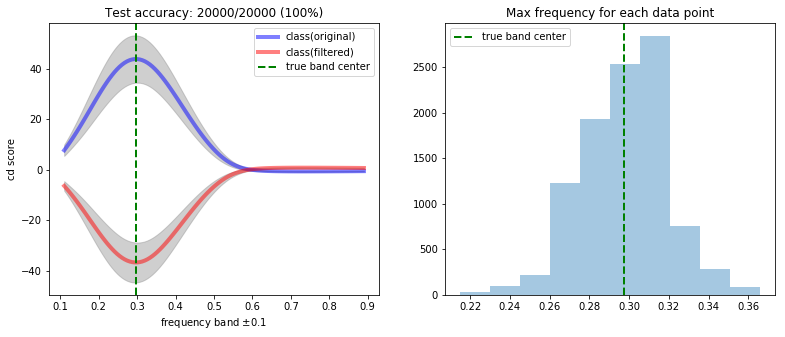

In [11]:
band_idx = 4
fig, ax = plt.subplots(1, 2, figsize=(13,5))
ax[0].plot(band_centers, scores0[band_idx,:].mean(axis=0), alpha=0.5, color='blue', label='class(original)', linewidth=4.0)
ax[0].fill_between(band_centers, scores0[band_idx,:].mean(axis=0)-scores0[band_idx,:].std(axis=0), 
                    scores0[band_idx,:].mean(axis=0)+scores0[band_idx,:].std(axis=0), color='#888888', alpha=0.4)
ax[0].plot(band_centers, scores1[band_idx,:].mean(axis=0), alpha=0.5, color='red', label='class(filtered)', linewidth=4.0)
ax[0].fill_between(band_centers, scores1[band_idx,:].mean(axis=0)-scores1[band_idx,:].std(axis=0), 
                    scores1[band_idx,:].mean(axis=0)+scores1[band_idx,:].std(axis=0), color='#888888', alpha=0.4)
ax[0].axvline(x=true_band_centers[band_idx], linestyle='--', color='green', label='true band center', linewidth=2.0)
ax[0].set_xlabel('frequency band $\pm 0.1$')
ax[0].set_ylabel('cd score')
ax[0].set_title('Test accuracy: {}/{} ({:.0f}%)'.format(accuracies[band_idx], 2*len(test_loader.dataset),
        100. * accuracies[band_idx] / (2*len(test_loader.dataset))))
ax[0].legend()

ax[1].hist(band_centers[np.argmax(scores0[band_idx,:],axis=1)], bins=10, alpha=0.4)
ax[1].axvline(x=true_band_centers[band_idx], linestyle='--', color='green', label='true band center', linewidth=2.0)
ax[1].legend()
ax[1].set_title('Max frequency for each data point')
plt.show()

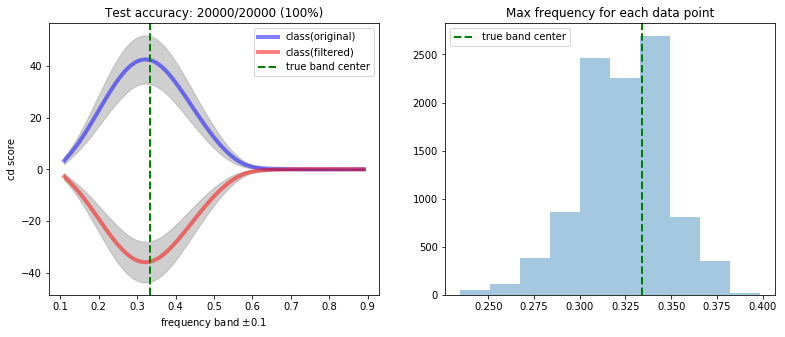

In [12]:
band_idx = 5
fig, ax = plt.subplots(1, 2, figsize=(13,5))
ax[0].plot(band_centers, scores0[band_idx,:].mean(axis=0), alpha=0.5, color='blue', label='class(original)', linewidth=4.0)
ax[0].fill_between(band_centers, scores0[band_idx,:].mean(axis=0)-scores0[band_idx,:].std(axis=0), 
                    scores0[band_idx,:].mean(axis=0)+scores0[band_idx,:].std(axis=0), color='#888888', alpha=0.4)
ax[0].plot(band_centers, scores1[band_idx,:].mean(axis=0), alpha=0.5, color='red', label='class(filtered)', linewidth=4.0)
ax[0].fill_between(band_centers, scores1[band_idx,:].mean(axis=0)-scores1[band_idx,:].std(axis=0), 
                    scores1[band_idx,:].mean(axis=0)+scores1[band_idx,:].std(axis=0), color='#888888', alpha=0.4)
ax[0].axvline(x=true_band_centers[band_idx], linestyle='--', color='green', label='true band center', linewidth=2.0)
ax[0].set_xlabel('frequency band $\pm 0.1$')
ax[0].set_ylabel('cd score')
ax[0].set_title('Test accuracy: {}/{} ({:.0f}%)'.format(accuracies[band_idx], 2*len(test_loader.dataset),
        100. * accuracies[band_idx] / (2*len(test_loader.dataset))))
ax[0].legend()

ax[1].hist(band_centers[np.argmax(scores0[band_idx,:],axis=1)], bins=10, alpha=0.4)
ax[1].axvline(x=true_band_centers[band_idx], linestyle='--', color='green', label='true band center', linewidth=2.0)
ax[1].legend()
ax[1].set_title('Max frequency for each data point')
plt.show()

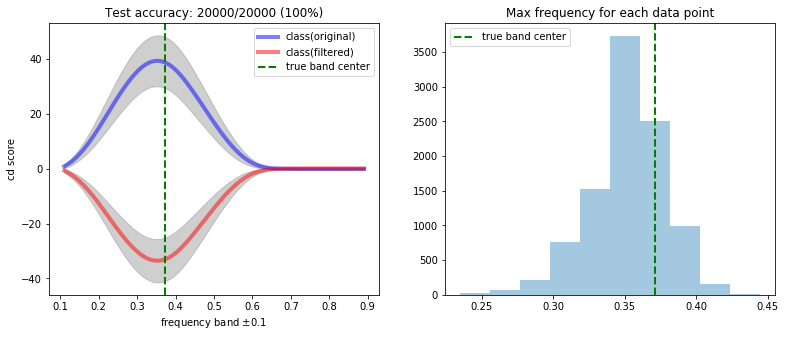

In [13]:
band_idx = 6
fig, ax = plt.subplots(1, 2, figsize=(13,5))
ax[0].plot(band_centers, scores0[band_idx,:].mean(axis=0), alpha=0.5, color='blue', label='class(original)', linewidth=4.0)
ax[0].fill_between(band_centers, scores0[band_idx,:].mean(axis=0)-scores0[band_idx,:].std(axis=0), 
                    scores0[band_idx,:].mean(axis=0)+scores0[band_idx,:].std(axis=0), color='#888888', alpha=0.4)
ax[0].plot(band_centers, scores1[band_idx,:].mean(axis=0), alpha=0.5, color='red', label='class(filtered)', linewidth=4.0)
ax[0].fill_between(band_centers, scores1[band_idx,:].mean(axis=0)-scores1[band_idx,:].std(axis=0), 
                    scores1[band_idx,:].mean(axis=0)+scores1[band_idx,:].std(axis=0), color='#888888', alpha=0.4)
ax[0].axvline(x=true_band_centers[band_idx], linestyle='--', color='green', label='true band center', linewidth=2.0)
ax[0].set_xlabel('frequency band $\pm 0.1$')
ax[0].set_ylabel('cd score')
ax[0].set_title('Test accuracy: {}/{} ({:.0f}%)'.format(accuracies[band_idx], 2*len(test_loader.dataset),
        100. * accuracies[band_idx] / (2*len(test_loader.dataset))))
ax[0].legend()

ax[1].hist(band_centers[np.argmax(scores0[band_idx,:],axis=1)], bins=10, alpha=0.4)
ax[1].axvline(x=true_band_centers[band_idx], linestyle='--', color='green', label='true band center', linewidth=2.0)
ax[1].legend()
ax[1].set_title('Max frequency for each data point')
plt.show()

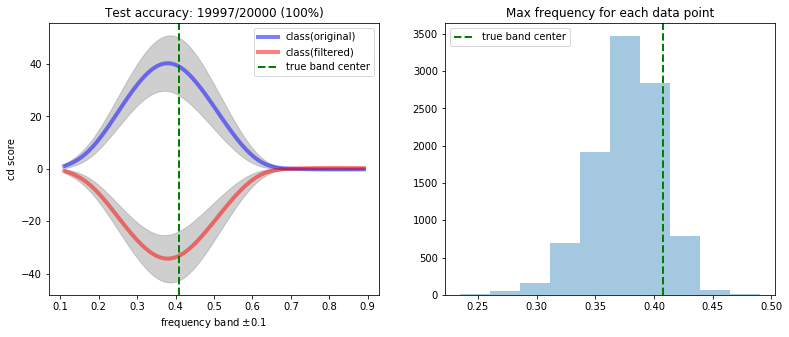

In [14]:
band_idx = 7
fig, ax = plt.subplots(1, 2, figsize=(13,5))
ax[0].plot(band_centers, scores0[band_idx,:].mean(axis=0), alpha=0.5, color='blue', label='class(original)', linewidth=4.0)
ax[0].fill_between(band_centers, scores0[band_idx,:].mean(axis=0)-scores0[band_idx,:].std(axis=0), 
                    scores0[band_idx,:].mean(axis=0)+scores0[band_idx,:].std(axis=0), color='#888888', alpha=0.4)
ax[0].plot(band_centers, scores1[band_idx,:].mean(axis=0), alpha=0.5, color='red', label='class(filtered)', linewidth=4.0)
ax[0].fill_between(band_centers, scores1[band_idx,:].mean(axis=0)-scores1[band_idx,:].std(axis=0), 
                    scores1[band_idx,:].mean(axis=0)+scores1[band_idx,:].std(axis=0), color='#888888', alpha=0.4)
ax[0].axvline(x=true_band_centers[band_idx], linestyle='--', color='green', label='true band center', linewidth=2.0)
ax[0].set_xlabel('frequency band $\pm 0.1$')
ax[0].set_ylabel('cd score')
ax[0].set_title('Test accuracy: {}/{} ({:.0f}%)'.format(accuracies[band_idx], 2*len(test_loader.dataset),
        100. * accuracies[band_idx] / (2*len(test_loader.dataset))))
ax[0].legend()

ax[1].hist(band_centers[np.argmax(scores0[band_idx,:],axis=1)], bins=10, alpha=0.4)
ax[1].axvline(x=true_band_centers[band_idx], linestyle='--', color='green', label='true band center', linewidth=2.0)
ax[1].legend()
ax[1].set_title('Max frequency for each data point')
plt.show()

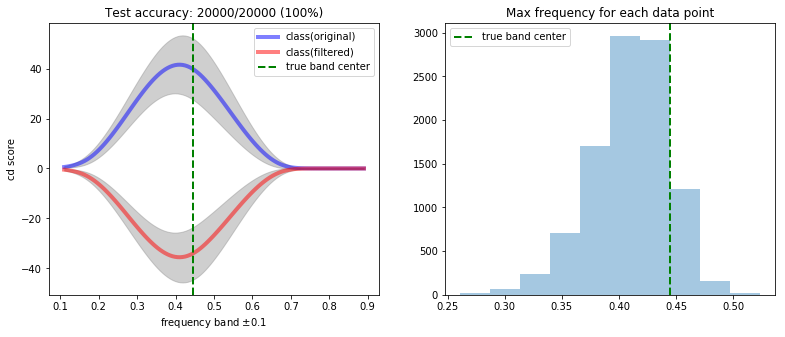

In [15]:
band_idx = 8
fig, ax = plt.subplots(1, 2, figsize=(13,5))
ax[0].plot(band_centers, scores0[band_idx,:].mean(axis=0), alpha=0.5, color='blue', label='class(original)', linewidth=4.0)
ax[0].fill_between(band_centers, scores0[band_idx,:].mean(axis=0)-scores0[band_idx,:].std(axis=0), 
                    scores0[band_idx,:].mean(axis=0)+scores0[band_idx,:].std(axis=0), color='#888888', alpha=0.4)
ax[0].plot(band_centers, scores1[band_idx,:].mean(axis=0), alpha=0.5, color='red', label='class(filtered)', linewidth=4.0)
ax[0].fill_between(band_centers, scores1[band_idx,:].mean(axis=0)-scores1[band_idx,:].std(axis=0), 
                    scores1[band_idx,:].mean(axis=0)+scores1[band_idx,:].std(axis=0), color='#888888', alpha=0.4)
ax[0].axvline(x=true_band_centers[band_idx], linestyle='--', color='green', label='true band center', linewidth=2.0)
ax[0].set_xlabel('frequency band $\pm 0.1$')
ax[0].set_ylabel('cd score')
ax[0].set_title('Test accuracy: {}/{} ({:.0f}%)'.format(accuracies[band_idx], 2*len(test_loader.dataset),
        100. * accuracies[band_idx] / (2*len(test_loader.dataset))))
ax[0].legend()

ax[1].hist(band_centers[np.argmax(scores0[band_idx,:],axis=1)], bins=10, alpha=0.4)
ax[1].axvline(x=true_band_centers[band_idx], linestyle='--', color='green', label='true band center', linewidth=2.0)
ax[1].legend()
ax[1].set_title('Max frequency for each data point')
plt.show()

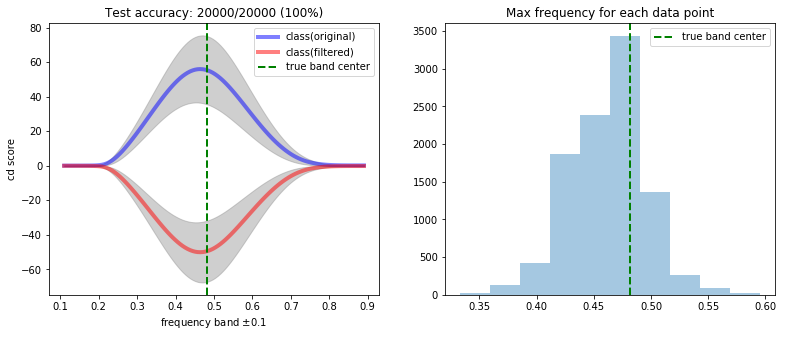

In [16]:
band_idx = 9
fig, ax = plt.subplots(1, 2, figsize=(13,5))
ax[0].plot(band_centers, scores0[band_idx,:].mean(axis=0), alpha=0.5, color='blue', label='class(original)', linewidth=4.0)
ax[0].fill_between(band_centers, scores0[band_idx,:].mean(axis=0)-scores0[band_idx,:].std(axis=0), 
                    scores0[band_idx,:].mean(axis=0)+scores0[band_idx,:].std(axis=0), color='#888888', alpha=0.4)
ax[0].plot(band_centers, scores1[band_idx,:].mean(axis=0), alpha=0.5, color='red', label='class(filtered)', linewidth=4.0)
ax[0].fill_between(band_centers, scores1[band_idx,:].mean(axis=0)-scores1[band_idx,:].std(axis=0), 
                    scores1[band_idx,:].mean(axis=0)+scores1[band_idx,:].std(axis=0), color='#888888', alpha=0.4)
ax[0].axvline(x=true_band_centers[band_idx], linestyle='--', color='green', label='true band center', linewidth=2.0)
ax[0].set_xlabel('frequency band $\pm 0.1$')
ax[0].set_ylabel('cd score')
ax[0].set_title('Test accuracy: {}/{} ({:.0f}%)'.format(accuracies[band_idx], 2*len(test_loader.dataset),
        100. * accuracies[band_idx] / (2*len(test_loader.dataset))))
ax[0].legend()

ax[1].hist(band_centers[np.argmax(scores0[band_idx,:],axis=1)], bins=10, alpha=0.4)
ax[1].axvline(x=true_band_centers[band_idx], linestyle='--', color='green', label='true band center', linewidth=2.0)
ax[1].legend()
ax[1].set_title('Max frequency for each data point')
plt.show()

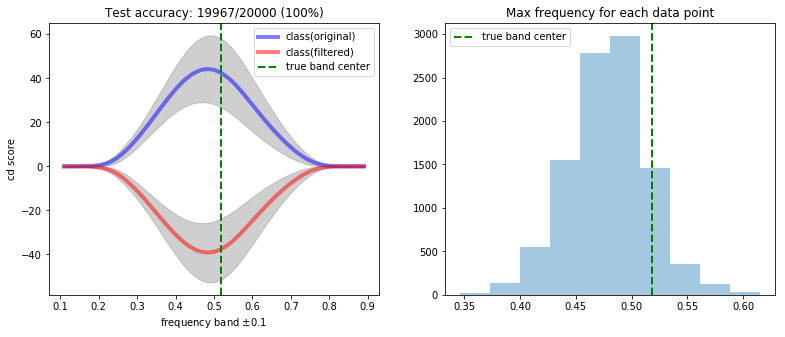

In [17]:
band_idx = 10
fig, ax = plt.subplots(1, 2, figsize=(13,5))
ax[0].plot(band_centers, scores0[band_idx,:].mean(axis=0), alpha=0.5, color='blue', label='class(original)', linewidth=4.0)
ax[0].fill_between(band_centers, scores0[band_idx,:].mean(axis=0)-scores0[band_idx,:].std(axis=0), 
                    scores0[band_idx,:].mean(axis=0)+scores0[band_idx,:].std(axis=0), color='#888888', alpha=0.4)
ax[0].plot(band_centers, scores1[band_idx,:].mean(axis=0), alpha=0.5, color='red', label='class(filtered)', linewidth=4.0)
ax[0].fill_between(band_centers, scores1[band_idx,:].mean(axis=0)-scores1[band_idx,:].std(axis=0), 
                    scores1[band_idx,:].mean(axis=0)+scores1[band_idx,:].std(axis=0), color='#888888', alpha=0.4)
ax[0].axvline(x=true_band_centers[band_idx], linestyle='--', color='green', label='true band center', linewidth=2.0)
ax[0].set_xlabel('frequency band $\pm 0.1$')
ax[0].set_ylabel('cd score')
ax[0].set_title('Test accuracy: {}/{} ({:.0f}%)'.format(accuracies[band_idx], 2*len(test_loader.dataset),
        100. * accuracies[band_idx] / (2*len(test_loader.dataset))))
ax[0].legend()

ax[1].hist(band_centers[np.argmax(scores0[band_idx,:],axis=1)], bins=10, alpha=0.4)
ax[1].axvline(x=true_band_centers[band_idx], linestyle='--', color='green', label='true band center', linewidth=2.0)
ax[1].legend()
ax[1].set_title('Max frequency for each data point')
plt.show()

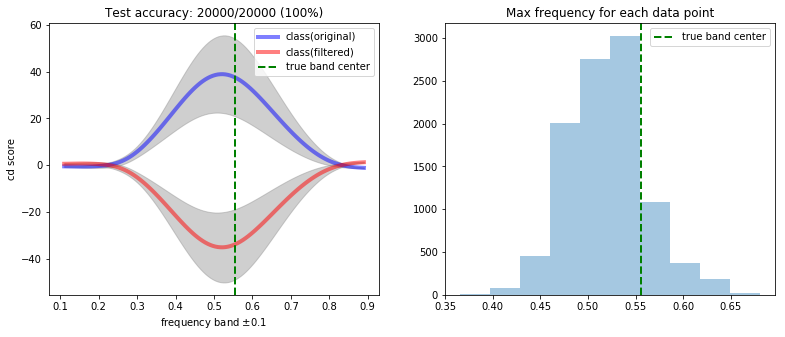

In [18]:
band_idx = 11
fig, ax = plt.subplots(1, 2, figsize=(13,5))
ax[0].plot(band_centers, scores0[band_idx,:].mean(axis=0), alpha=0.5, color='blue', label='class(original)', linewidth=4.0)
ax[0].fill_between(band_centers, scores0[band_idx,:].mean(axis=0)-scores0[band_idx,:].std(axis=0), 
                    scores0[band_idx,:].mean(axis=0)+scores0[band_idx,:].std(axis=0), color='#888888', alpha=0.4)
ax[0].plot(band_centers, scores1[band_idx,:].mean(axis=0), alpha=0.5, color='red', label='class(filtered)', linewidth=4.0)
ax[0].fill_between(band_centers, scores1[band_idx,:].mean(axis=0)-scores1[band_idx,:].std(axis=0), 
                    scores1[band_idx,:].mean(axis=0)+scores1[band_idx,:].std(axis=0), color='#888888', alpha=0.4)
ax[0].axvline(x=true_band_centers[band_idx], linestyle='--', color='green', label='true band center', linewidth=2.0)
ax[0].set_xlabel('frequency band $\pm 0.1$')
ax[0].set_ylabel('cd score')
ax[0].set_title('Test accuracy: {}/{} ({:.0f}%)'.format(accuracies[band_idx], 2*len(test_loader.dataset),
        100. * accuracies[band_idx] / (2*len(test_loader.dataset))))
ax[0].legend()

ax[1].hist(band_centers[np.argmax(scores0[band_idx,:],axis=1)], bins=10, alpha=0.4)
ax[1].axvline(x=true_band_centers[band_idx], linestyle='--', color='green', label='true band center', linewidth=2.0)
ax[1].legend()
ax[1].set_title('Max frequency for each data point')
plt.show()

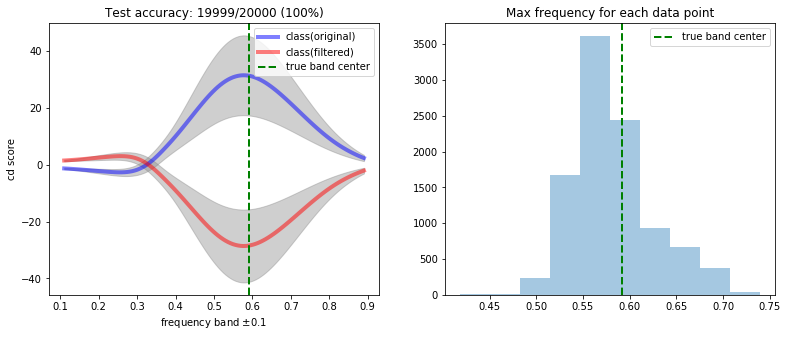

In [19]:
band_idx = 12
fig, ax = plt.subplots(1, 2, figsize=(13,5))
ax[0].plot(band_centers, scores0[band_idx,:].mean(axis=0), alpha=0.5, color='blue', label='class(original)', linewidth=4.0)
ax[0].fill_between(band_centers, scores0[band_idx,:].mean(axis=0)-scores0[band_idx,:].std(axis=0), 
                    scores0[band_idx,:].mean(axis=0)+scores0[band_idx,:].std(axis=0), color='#888888', alpha=0.4)
ax[0].plot(band_centers, scores1[band_idx,:].mean(axis=0), alpha=0.5, color='red', label='class(filtered)', linewidth=4.0)
ax[0].fill_between(band_centers, scores1[band_idx,:].mean(axis=0)-scores1[band_idx,:].std(axis=0), 
                    scores1[band_idx,:].mean(axis=0)+scores1[band_idx,:].std(axis=0), color='#888888', alpha=0.4)
ax[0].axvline(x=true_band_centers[band_idx], linestyle='--', color='green', label='true band center', linewidth=2.0)
ax[0].set_xlabel('frequency band $\pm 0.1$')
ax[0].set_ylabel('cd score')
ax[0].set_title('Test accuracy: {}/{} ({:.0f}%)'.format(accuracies[band_idx], 2*len(test_loader.dataset),
        100. * accuracies[band_idx] / (2*len(test_loader.dataset))))
ax[0].legend()

ax[1].hist(band_centers[np.argmax(scores0[band_idx,:],axis=1)], bins=10, alpha=0.4)
ax[1].axvline(x=true_band_centers[band_idx], linestyle='--', color='green', label='true band center', linewidth=2.0)
ax[1].legend()
ax[1].set_title('Max frequency for each data point')
plt.show()

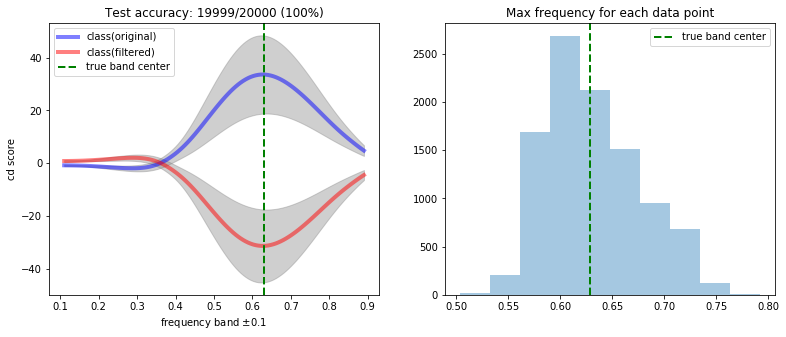

In [20]:
band_idx = 13
fig, ax = plt.subplots(1, 2, figsize=(13,5))
ax[0].plot(band_centers, scores0[band_idx,:].mean(axis=0), alpha=0.5, color='blue', label='class(original)', linewidth=4.0)
ax[0].fill_between(band_centers, scores0[band_idx,:].mean(axis=0)-scores0[band_idx,:].std(axis=0), 
                    scores0[band_idx,:].mean(axis=0)+scores0[band_idx,:].std(axis=0), color='#888888', alpha=0.4)
ax[0].plot(band_centers, scores1[band_idx,:].mean(axis=0), alpha=0.5, color='red', label='class(filtered)', linewidth=4.0)
ax[0].fill_between(band_centers, scores1[band_idx,:].mean(axis=0)-scores1[band_idx,:].std(axis=0), 
                    scores1[band_idx,:].mean(axis=0)+scores1[band_idx,:].std(axis=0), color='#888888', alpha=0.4)
ax[0].axvline(x=true_band_centers[band_idx], linestyle='--', color='green', label='true band center', linewidth=2.0)
ax[0].set_xlabel('frequency band $\pm 0.1$')
ax[0].set_ylabel('cd score')
ax[0].set_title('Test accuracy: {}/{} ({:.0f}%)'.format(accuracies[band_idx], 2*len(test_loader.dataset),
        100. * accuracies[band_idx] / (2*len(test_loader.dataset))))
ax[0].legend()

ax[1].hist(band_centers[np.argmax(scores0[band_idx,:],axis=1)], bins=10, alpha=0.4)
ax[1].axvline(x=true_band_centers[band_idx], linestyle='--', color='green', label='true band center', linewidth=2.0)
ax[1].legend()
ax[1].set_title('Max frequency for each data point')
plt.show()

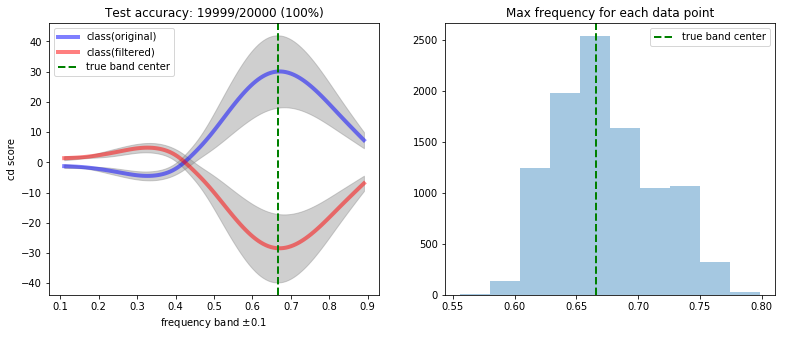

In [21]:
band_idx = 14
fig, ax = plt.subplots(1, 2, figsize=(13,5))
ax[0].plot(band_centers, scores0[band_idx,:].mean(axis=0), alpha=0.5, color='blue', label='class(original)', linewidth=4.0)
ax[0].fill_between(band_centers, scores0[band_idx,:].mean(axis=0)-scores0[band_idx,:].std(axis=0), 
                    scores0[band_idx,:].mean(axis=0)+scores0[band_idx,:].std(axis=0), color='#888888', alpha=0.4)
ax[0].plot(band_centers, scores1[band_idx,:].mean(axis=0), alpha=0.5, color='red', label='class(filtered)', linewidth=4.0)
ax[0].fill_between(band_centers, scores1[band_idx,:].mean(axis=0)-scores1[band_idx,:].std(axis=0), 
                    scores1[band_idx,:].mean(axis=0)+scores1[band_idx,:].std(axis=0), color='#888888', alpha=0.4)
ax[0].axvline(x=true_band_centers[band_idx], linestyle='--', color='green', label='true band center', linewidth=2.0)
ax[0].set_xlabel('frequency band $\pm 0.1$')
ax[0].set_ylabel('cd score')
ax[0].set_title('Test accuracy: {}/{} ({:.0f}%)'.format(accuracies[band_idx], 2*len(test_loader.dataset),
        100. * accuracies[band_idx] / (2*len(test_loader.dataset))))
ax[0].legend()

ax[1].hist(band_centers[np.argmax(scores0[band_idx,:],axis=1)], bins=10, alpha=0.4)
ax[1].axvline(x=true_band_centers[band_idx], linestyle='--', color='green', label='true band center', linewidth=2.0)
ax[1].legend()
ax[1].set_title('Max frequency for each data point')
plt.show()

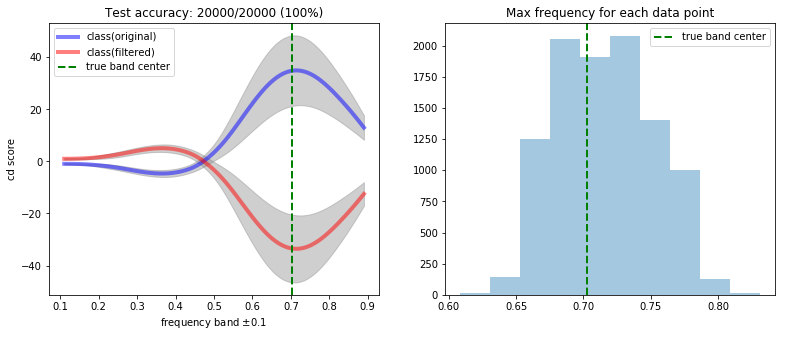

In [22]:
band_idx = 15
fig, ax = plt.subplots(1, 2, figsize=(13,5))
ax[0].plot(band_centers, scores0[band_idx,:].mean(axis=0), alpha=0.5, color='blue', label='class(original)', linewidth=4.0)
ax[0].fill_between(band_centers, scores0[band_idx,:].mean(axis=0)-scores0[band_idx,:].std(axis=0), 
                    scores0[band_idx,:].mean(axis=0)+scores0[band_idx,:].std(axis=0), color='#888888', alpha=0.4)
ax[0].plot(band_centers, scores1[band_idx,:].mean(axis=0), alpha=0.5, color='red', label='class(filtered)', linewidth=4.0)
ax[0].fill_between(band_centers, scores1[band_idx,:].mean(axis=0)-scores1[band_idx,:].std(axis=0), 
                    scores1[band_idx,:].mean(axis=0)+scores1[band_idx,:].std(axis=0), color='#888888', alpha=0.4)
ax[0].axvline(x=true_band_centers[band_idx], linestyle='--', color='green', label='true band center', linewidth=2.0)
ax[0].set_xlabel('frequency band $\pm 0.1$')
ax[0].set_ylabel('cd score')
ax[0].set_title('Test accuracy: {}/{} ({:.0f}%)'.format(accuracies[band_idx], 2*len(test_loader.dataset),
        100. * accuracies[band_idx] / (2*len(test_loader.dataset))))
ax[0].legend()

ax[1].hist(band_centers[np.argmax(scores0[band_idx,:],axis=1)], bins=10, alpha=0.4)
ax[1].axvline(x=true_band_centers[band_idx], linestyle='--', color='green', label='true band center', linewidth=2.0)
ax[1].legend()
ax[1].set_title('Max frequency for each data point')
plt.show()

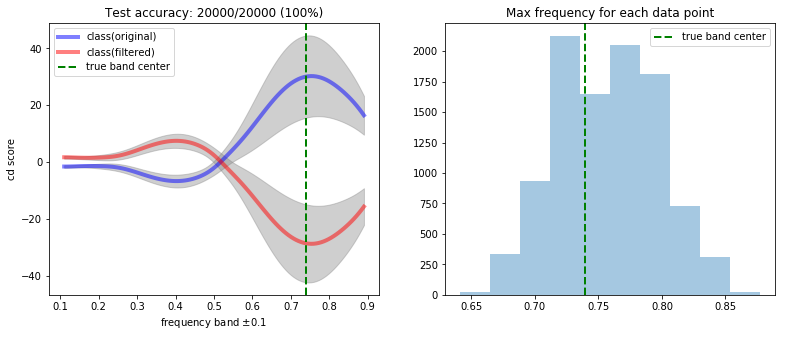

In [23]:
band_idx = 16
fig, ax = plt.subplots(1, 2, figsize=(13,5))
ax[0].plot(band_centers, scores0[band_idx,:].mean(axis=0), alpha=0.5, color='blue', label='class(original)', linewidth=4.0)
ax[0].fill_between(band_centers, scores0[band_idx,:].mean(axis=0)-scores0[band_idx,:].std(axis=0), 
                    scores0[band_idx,:].mean(axis=0)+scores0[band_idx,:].std(axis=0), color='#888888', alpha=0.4)
ax[0].plot(band_centers, scores1[band_idx,:].mean(axis=0), alpha=0.5, color='red', label='class(filtered)', linewidth=4.0)
ax[0].fill_between(band_centers, scores1[band_idx,:].mean(axis=0)-scores1[band_idx,:].std(axis=0), 
                    scores1[band_idx,:].mean(axis=0)+scores1[band_idx,:].std(axis=0), color='#888888', alpha=0.4)
ax[0].axvline(x=true_band_centers[band_idx], linestyle='--', color='green', label='true band center', linewidth=2.0)
ax[0].set_xlabel('frequency band $\pm 0.1$')
ax[0].set_ylabel('cd score')
ax[0].set_title('Test accuracy: {}/{} ({:.0f}%)'.format(accuracies[band_idx], 2*len(test_loader.dataset),
        100. * accuracies[band_idx] / (2*len(test_loader.dataset))))
ax[0].legend()

ax[1].hist(band_centers[np.argmax(scores0[band_idx,:],axis=1)], bins=10, alpha=0.4)
ax[1].axvline(x=true_band_centers[band_idx], linestyle='--', color='green', label='true band center', linewidth=2.0)
ax[1].legend()
ax[1].set_title('Max frequency for each data point')
plt.show()

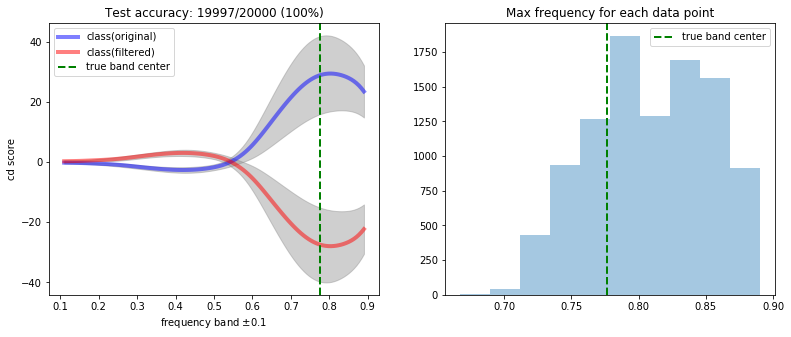

In [24]:
band_idx = 17
fig, ax = plt.subplots(1, 2, figsize=(13,5))
ax[0].plot(band_centers, scores0[band_idx,:].mean(axis=0), alpha=0.5, color='blue', label='class(original)', linewidth=4.0)
ax[0].fill_between(band_centers, scores0[band_idx,:].mean(axis=0)-scores0[band_idx,:].std(axis=0), 
                    scores0[band_idx,:].mean(axis=0)+scores0[band_idx,:].std(axis=0), color='#888888', alpha=0.4)
ax[0].plot(band_centers, scores1[band_idx,:].mean(axis=0), alpha=0.5, color='red', label='class(filtered)', linewidth=4.0)
ax[0].fill_between(band_centers, scores1[band_idx,:].mean(axis=0)-scores1[band_idx,:].std(axis=0), 
                    scores1[band_idx,:].mean(axis=0)+scores1[band_idx,:].std(axis=0), color='#888888', alpha=0.4)
ax[0].axvline(x=true_band_centers[band_idx], linestyle='--', color='green', label='true band center', linewidth=2.0)
ax[0].set_xlabel('frequency band $\pm 0.1$')
ax[0].set_ylabel('cd score')
ax[0].set_title('Test accuracy: {}/{} ({:.0f}%)'.format(accuracies[band_idx], 2*len(test_loader.dataset),
        100. * accuracies[band_idx] / (2*len(test_loader.dataset))))
ax[0].legend()

ax[1].hist(band_centers[np.argmax(scores0[band_idx,:],axis=1)], bins=10, alpha=0.4)
ax[1].axvline(x=true_band_centers[band_idx], linestyle='--', color='green', label='true band center', linewidth=2.0)
ax[1].legend()
ax[1].set_title('Max frequency for each data point')
plt.show()

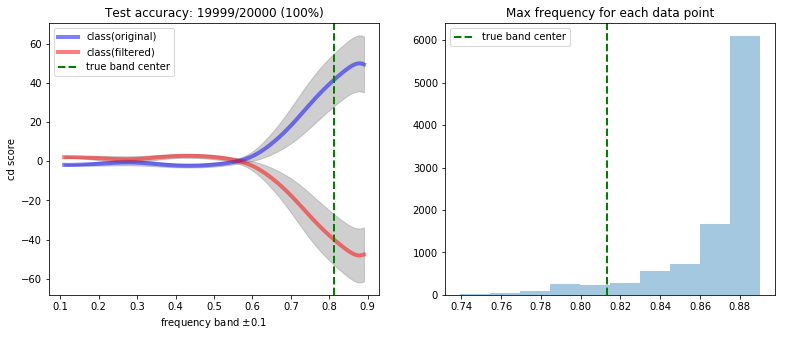

In [25]:
band_idx = 18
fig, ax = plt.subplots(1, 2, figsize=(13,5))
ax[0].plot(band_centers, scores0[band_idx,:].mean(axis=0), alpha=0.5, color='blue', label='class(original)', linewidth=4.0)
ax[0].fill_between(band_centers, scores0[band_idx,:].mean(axis=0)-scores0[band_idx,:].std(axis=0), 
                    scores0[band_idx,:].mean(axis=0)+scores0[band_idx,:].std(axis=0), color='#888888', alpha=0.4)
ax[0].plot(band_centers, scores1[band_idx,:].mean(axis=0), alpha=0.5, color='red', label='class(filtered)', linewidth=4.0)
ax[0].fill_between(band_centers, scores1[band_idx,:].mean(axis=0)-scores1[band_idx,:].std(axis=0), 
                    scores1[band_idx,:].mean(axis=0)+scores1[band_idx,:].std(axis=0), color='#888888', alpha=0.4)
ax[0].axvline(x=true_band_centers[band_idx], linestyle='--', color='green', label='true band center', linewidth=2.0)
ax[0].set_xlabel('frequency band $\pm 0.1$')
ax[0].set_ylabel('cd score')
ax[0].set_title('Test accuracy: {}/{} ({:.0f}%)'.format(accuracies[band_idx], 2*len(test_loader.dataset),
        100. * accuracies[band_idx] / (2*len(test_loader.dataset))))
ax[0].legend()

ax[1].hist(band_centers[np.argmax(scores0[band_idx,:],axis=1)], bins=10, alpha=0.4)
ax[1].axvline(x=true_band_centers[band_idx], linestyle='--', color='green', label='true band center', linewidth=2.0)
ax[1].legend()
ax[1].set_title('Max frequency for each data point')
plt.show()

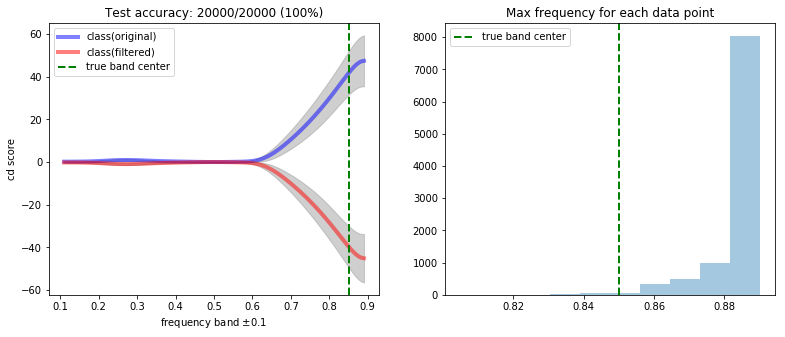

In [26]:
band_idx = 19
fig, ax = plt.subplots(1, 2, figsize=(13,5))
ax[0].plot(band_centers, scores0[band_idx,:].mean(axis=0), alpha=0.5, color='blue', label='class(original)', linewidth=4.0)
ax[0].fill_between(band_centers, scores0[band_idx,:].mean(axis=0)-scores0[band_idx,:].std(axis=0), 
                    scores0[band_idx,:].mean(axis=0)+scores0[band_idx,:].std(axis=0), color='#888888', alpha=0.4)
ax[0].plot(band_centers, scores1[band_idx,:].mean(axis=0), alpha=0.5, color='red', label='class(filtered)', linewidth=4.0)
ax[0].fill_between(band_centers, scores1[band_idx,:].mean(axis=0)-scores1[band_idx,:].std(axis=0), 
                    scores1[band_idx,:].mean(axis=0)+scores1[band_idx,:].std(axis=0), color='#888888', alpha=0.4)
ax[0].axvline(x=true_band_centers[band_idx], linestyle='--', color='green', label='true band center', linewidth=2.0)
ax[0].set_xlabel('frequency band $\pm 0.1$')
ax[0].set_ylabel('cd score')
ax[0].set_title('Test accuracy: {}/{} ({:.0f}%)'.format(accuracies[band_idx], 2*len(test_loader.dataset),
        100. * accuracies[band_idx] / (2*len(test_loader.dataset))))
ax[0].legend()

ax[1].hist(band_centers[np.argmax(scores0[band_idx,:],axis=1)], bins=10, alpha=0.4)
ax[1].axvline(x=true_band_centers[band_idx], linestyle='--', color='green', label='true band center', linewidth=2.0)
ax[1].legend()
ax[1].set_title('Max frequency for each data point')
plt.show()